## [作業重點]
了解如何使用 Sklearn 中的 hyper-parameter search 找出最佳的超參數

### 作業
請使用不同的資料集，並使用 hyper-parameter search 的方式，看能不能找出最佳的超參數組合

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy import stats
from sklearn import datasets, tree, metrics
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
boston = datasets.load_boston()
ss_scaler = StandardScaler()
boston_data_ss = ss_scaler.fit_transform(boston.data) 
x_train_ss, x_test_ss, y_train_ss, y_test_ss = train_test_split(boston_data_ss, boston.target, random_state=4, test_size=0.25)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=4, test_size=0.25)

In [5]:
#DecisionTreeRegressor()
LR_reg = tree.DecisionTreeRegressor(random_state=0)
result_LR_reg = cross_val_score(LR_reg,x_train_ss, y_train_ss, scoring='r2', cv=5, verbose=1, n_jobs=-1)
print('Training_r2:{:.3} +/- {:.3} with 95% CI:\n{}'.format(np.mean(result_LR_reg), np.std(result_LR_reg)*2, result_LR_reg))
LR_reg.fit(x_train_ss, y_train_ss)
y_pred_LR = LR_reg.predict(x_test_ss)
print('Test_r2:{:.3}'.format(metrics.r2_score(y_test_ss, y_pred_LR)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training_r2:0.705 +/- 0.171 with 95% CI:
[0.7855102  0.68220314 0.79775015 0.70167342 0.56010866]
Test_r2:0.733


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


In [91]:
#RandomizedSearchCV 
param_dist = {'max_depth':[i for i in range(1, 11)], 'min_samples_split':[i for i in range(2, 6)],
              'max_features':[i for i in range(1, len(boston.feature_names))]}
tree_random_cv = RandomizedSearchCV(LR_reg, param_dist, scoring='r2',n_iter=150, iid=False, cv=5,
                                    return_train_score=True, verbose=1)
tree_random_cv.fit(x_train, y_train)
print(tree_random_cv.best_score_, tree_random_cv.best_params_)
tree_reg = tree.DecisionTreeRegressor(max_depth=tree_random_cv.best_params_['max_depth'],
                                      max_features=tree_random_cv.best_params_['max_features'],
                                      min_samples_split=tree_random_cv.best_params_['min_samples_split'])
tree_reg.fit(x_train, y_train)
y_pred_tree = tree_reg.predict(x_test)
print('test r2:', metrics.r2_score(y_test, y_pred_tree))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7813903685964009 {'min_samples_split': 3, 'max_features': 9, 'max_depth': 7}
test r2: 0.843652322653574


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    1.3s finished


In [82]:
#GridSearchCV
param_grid = {'max_depth':[i for i in range(1, 11)], 'min_samples_split':[i for i in range(2, 6)],
              'max_features':[i for i in range(1, len(boston.feature_names))]}
tree_cv_reg = GridSearchCV(LR_reg, param_grid, scoring='r2',iid=False, cv=5, return_train_score=True, verbose=1,)
tree_cv_reg.fit(x_train, y_train)
print(tree_cv_reg.best_score_, tree_cv_reg.best_params_)
tree_reg = tree.DecisionTreeRegressor(max_depth=tree_cv_reg.best_params_['max_depth'],
                                      max_features=tree_cv_reg.best_params_['max_features'],
                                      min_samples_split=tree_cv_reg.best_params_['min_samples_split'])
tree_reg.fit(x_train, y_train)
y_pred_tree = tree_reg.predict(x_test)
print('test r2:', metrics.r2_score(y_test, y_pred_tree))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7813903685964009 {'max_depth': 7, 'max_features': 9, 'min_samples_split': 3}
test r2: 0.7294697790696983


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    4.2s finished


In [94]:
#GridSearchCV 2 feature for visulization
param_grid = {'max_depth':[i for i in range(1, 11)],
              'max_features':[i for i in range(1, len(boston.feature_names))]}
tree_cv_reg = GridSearchCV(LR_reg, param_grid, scoring='r2',iid=False, cv=5, return_train_score=True, verbose=1,)
tree_cv_reg.fit(x_train, y_train)
print(tree_cv_reg.best_score_, tree_cv_reg.best_params_)
tree_reg = tree.DecisionTreeRegressor(max_depth=tree_cv_reg.best_params_['max_depth'],
                                      max_features=tree_cv_reg.best_params_['max_features'],
                                      min_samples_split=3)
tree_reg.fit(x_train, y_train)
y_pred_tree = tree_reg.predict(x_test)
print('test r2:', metrics.r2_score(y_test, y_pred_tree))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.76330034704854 {'max_depth': 8, 'max_features': 11}
test r2: 0.7915867976285469


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.1s finished


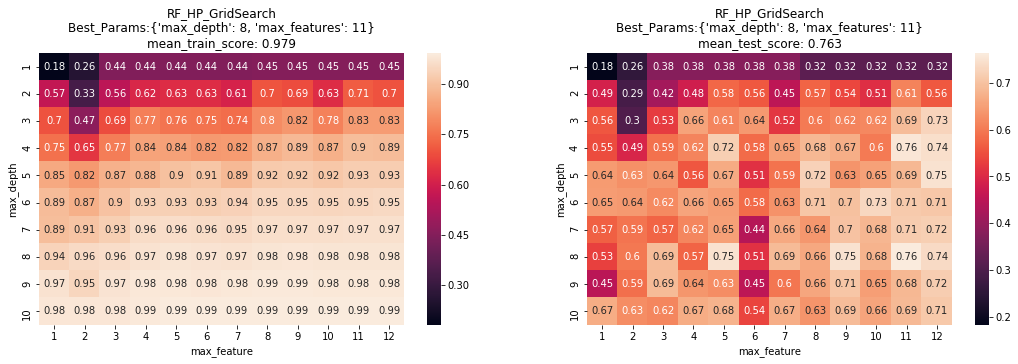

In [101]:
#check RF GridSearch result
plt.figure(figsize=(18,5))
result = pd.DataFrame(tree_cv_reg.cv_results_)
for i, condition in enumerate(['mean_train_score', 'mean_test_score']):
    plt.subplot(1, 2, i+1)
    sns.heatmap(pd.DataFrame(tree_cv_reg.cv_results_[condition].reshape(-1,len(tree_cv_reg.param_grid['max_features'])),
                             index = tree_cv_reg.param_grid['max_depth'],
                             columns = tree_cv_reg.param_grid['max_features']),annot=True, fmt='.2g')
    plt.ylabel('max_depth')
    plt.xlabel('max_feature')
    best_score = result.loc[np.array(result['param_max_depth'] == tree_cv_reg.best_params_['max_depth']) & \
               np.array(result['param_max_features']== tree_cv_reg.best_params_['max_features']), [condition]].values
    plt.title('RF_HP_GridSearch\nBest_Params:'+str(tree_cv_reg.best_params_)+
              '\n'+str(condition)+': '+ str(round(best_score[0, 0], 3)))

In [99]:
#GradientBoostingClassifier
GB_reg = GradientBoostingRegressor()
result_GB_reg = cross_val_score(GB_reg,x_train, y_train, scoring='r2', cv=5, verbose=1, n_jobs=-1)
print('Training_r2:{} +/- {} with 95% CI:\n{}'.format(np.mean(result_GB_reg), np.std(result_GB_reg)*2, result_GB_reg))
GB_reg.fit(x_train, y_train)
y_pred_GB = GB_reg.predict(x_test)
print('Test_r2:{}'.format(metrics.r2_score(y_test, y_pred_GB)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training_r2:0.8541048955598345 +/- 0.07617845942966851 with 95% CI:
[0.8621646  0.86151057 0.91737385 0.81871493 0.81076053]
Test_r2:0.8819874721942584


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


In [110]:
#RandomSearchCV
param_grid = {'learning_rate':[10**i for i in range(-5, 1)], 'n_estimators':[i for i in range(2, 103, 10)],
              'max_depth':[i for i in range(1, 11)],
              'max_features':[i for i in range(1, len(boston.feature_names))]}
grid = RandomizedSearchCV(GradientBoostingRegressor(), param_grid, scoring='r2',iid=False, cv=5, n_iter=100,
                    return_train_score=True, verbose=1, n_jobs=-1)
grid.fit(x_train, y_train)
print(grid.best_score_, grid.best_params_)

GB_reg = GradientBoostingRegressor(learning_rate=grid.best_params_['learning_rate'],
                                   n_estimators=grid.best_params_['n_estimators'],
                                   max_depth = grid.best_params_['max_depth'],
                                   max_features=grid.best_params_['max_features'])                                   
GB_reg.fit(x_train, y_train)
y_pred_tree = GB_reg.predict(x_test)
print('test r2:', metrics.r2_score(y_test, y_pred_tree))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    3.6s


0.8625187080802641 {'n_estimators': 52, 'max_features': 9, 'max_depth': 3, 'learning_rate': 0.1}
test r2: 0.8876614006303855


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.5s finished


In [111]:
#GridSearchCV
param_grid = {'learning_rate':[10**i for i in range(-5, 1)], 'n_estimators':[i for i in range(2, 103, 10)],
              'max_depth':[i for i in range(1, 11)],
              'max_features':[i for i in range(1, len(boston.feature_names))]}
grid = GridSearchCV(GradientBoostingRegressor(), param_grid, scoring='r2',iid=False, cv=5,
                    return_train_score=True, verbose=1, n_jobs=-1)
grid.fit(x_train, y_train)
print(grid.best_score_, grid.best_params_)




Fitting 5 folds for each of 7920 candidates, totalling 39600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 5138 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6888 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 11888 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 15138 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 18888 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 23138 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 26760 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 32813 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 39593 out of 39600 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 39600 out of 39600 | elapsed: 12.0min finished


0.8784246151258097 {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 4, 'n_estimators': 82}


AttributeError: 'GridSearchCV' object has no attribute 'best_paras_'

In [112]:
GB_reg = GradientBoostingRegressor(learning_rate=grid.best_params_['learning_rate'],
                                   n_estimators=grid.best_params_['n_estimators'],
                                   max_depth = grid.best_params_['max_depth'],
                                   max_features=grid.best_params_['max_features'])                                   
GB_reg.fit(x_train, y_train)
y_pred_tree = GB_reg.predict(x_test)
print('test r2:', metrics.r2_score(y_test, y_pred_tree))

test r2: 0.9068940576952476


In [100]:
#RandomForestClassifier
RF_reg = RandomForestRegressor()
result_RF_reg = cross_val_score(RF_reg,x_train, y_train, scoring='r2', cv=5, verbose=1, n_jobs=-1)
print('Training_r2:{:.3} +/- {:.3} with 95% CI:\n{}'.format(np.mean(result_RF_reg), np.std(result_RF_reg)*2, result_RF_reg))
RF_reg.fit(x_train, y_train)
y_pred_RF = RF_reg.predict(x_test)
print('Test_r2:{:.3}'.format(metrics.r2_score(y_test, y_pred_RF)))

Training_r2:0.82 +/- 0.153 with 95% CI:
[0.85553674 0.8498283  0.91417193 0.79244259 0.68831903]
Test_r2:0.839


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [115]:
#RandomSearchCV
param_dist = {'n_estimators':[i for i in range(2, 103, 20)], 'max_depth':[i for i in range(1, 11)],
              'max_features':[i for i in range(1, len(boston.feature_names))],
              'min_samples_split':[i for i in range(2, 50, 10)]}
rand = RandomizedSearchCV(RandomForestRegressor(), param_dist, n_iter=150, n_jobs=-1,
                   cv=5, verbose=1, return_train_score=True)
rand.fit(x_train, y_train)
print(rand.best_score_, rand.best_params_)
RF_reg = RandomForestRegressor(n_estimators = rand.best_params_['n_estimators'],
                               max_depth = rand.best_params_['max_depth'],
                               max_features = rand.best_params_['max_features'],
                               min_samples_split = rand.best_params_['min_samples_split'])
RF_reg.fit(x_train, y_train)
print('Test_R2_Score:{:.3}'.format(metrics.r2_score(y_test, RF_reg.predict(x_test))))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 743 out of 750 | elapsed:   18.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   18.8s finished


0.8462770488061827 {'n_estimators': 82, 'min_samples_split': 2, 'max_features': 7, 'max_depth': 10}
Test_R2_Score:0.88


In [133]:
#RandomSearchCV 2
param_dist = {'n_estimators':np.random.randint(2, 101, size=100), 'max_depth':np.random.randint(1, 11, size=[5]),
              'max_features':np.random.randint(2, len(boston.feature_names)+1, size=len(boston.feature_names)),
              'min_samples_split':np.random.randint(2, 51, size=100)}
rand = RandomizedSearchCV(RandomForestRegressor(), param_dist, n_iter=150, n_jobs=-1,
                   cv=5, verbose=1, return_train_score=True)
rand.fit(x_train, y_train)
print(rand.best_score_, rand.best_params_)
RF_reg = RandomForestRegressor(n_estimators = rand.best_params_['n_estimators'],
                               max_depth = rand.best_params_['max_depth'],
                               max_features = rand.best_params_['max_features'],
                               min_samples_split = rand.best_params_['min_samples_split'])
RF_reg.fit(x_train, y_train)
print('Test_R2_Score:{:.3}'.format(metrics.r2_score(y_test, RF_reg.predict(x_test))))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 367 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 743 out of 750 | elapsed:   19.7s remaining:    0.1s


0.8555812280199296 {'n_estimators': 14, 'min_samples_split': 7, 'max_features': 7, 'max_depth': 10}
Test_R2_Score:0.875


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   19.9s finished
